# King County Housing Predictions
### Using Linear Regression to predict housing prices in Seatle

## Table of Contents
### 1) Geolocation Data
### 2) Time Series Data
### 3) Feature Interactions
### 4) Constructing my model piecewise
### 5) Testing the model
### 6) Lasso regression 


In [1]:
import src 

# sklearn packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler ,minmax_scale

# Statsmodels
from statsmodels.formula.api import ols

# Geolocation
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# utility libraries 
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geohash2

import warnings 

# filter warnings
warnings.filterwarnings("ignore")

# magic inline
%matplotlib inline

In [2]:
# geopandas = gpd.read_file('./cleanedData/geopandasTraining.csv')
geo = pd.read_csv('./cleanedData/geoOverlap.csv')
X = pd.read_csv('./cleanedData/X.imputed.csv', index_col=0)
y = pd.read_csv('./raw/y.csv', header = None)
y.columns = ['price']
holdout = pd.read_csv('./raw/kc_holdout_data.csv')
training_data = pd.concat([X, y], axis=1)

### I will change the yr built to age of building and the sqft_basement column to a dummy

In [3]:
# convert to years_old from years built

X.yr_built = X.yr_built.apply(lambda x: 2016-x)

# Convert basement to dummy column, yes or no

X.sqft_basement = X.sqft_basement.apply(lambda x: x!=0)

## Dealing with Geolocation Data



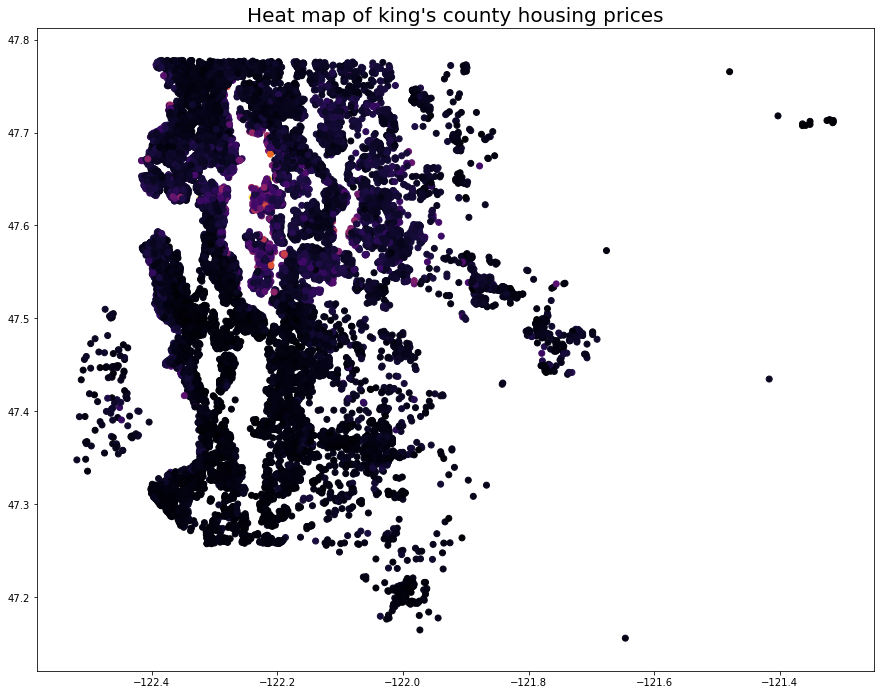

In [4]:
# Let's get rid of the everything but the price, longitude and latitude for now
geometry = [Point(xy) for xy in zip(training_data["long"], training_data["lat"])]
geometry[:5]

# Horizontal component of 3D system. 
# Used by the GPS satellite navigation 
# system and for NATO military geodetic surveying.
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(training_data,
                         crs=crs,
                         geometry=geometry)


fig,ax = plt.subplots(figsize = (15,15))
# ax.set_ylim(5900000, 6300000)
# map_df.plot(ax=ax, alpha=0.4, color="blue")
geo_df.plot(ax=ax, column ='price', cmap = 'inferno')
plt.title("Heat map of king's county housing prices", size = (20));

### If I had more time I would create a folium map with city limits but the story of the data is quite clear.

There is a tight region where the housing prices are particulalry high. They surround a body of water so anything near a coast should have higher prices. In our data set, houses with an ocean view have a significantly higher median price.

I would also like to look at distance from pubplc parks

In [5]:
delta=training_data[training_data.waterfront == 1].price.median() - training_data[training_data.waterfront == 0].price.median()

In [6]:
stats.levene(training_data[training_data.waterfront == 1].price, 
              training_data[training_data.waterfront == 0].price)
stat= stats.ttest_ind(training_data[training_data.waterfront == 1].price,
                training_data[training_data.waterfront == 0].price, 
                equal_var=False)



In [7]:
print(f'The median difference in price between homes with a coastal view and those with out is {delta} \
which is statistically signeficant with a p_value of {stat[1]}')

The median difference in price between homes with a coastal view and those with out is 955000.0 which is statistically signeficant with a p_value of 6.940441256090536e-23


#### Latitude and Longitude as Features

From my analysis, latitude is one of the most important predicters of price (see `interactions`). This makes sense. Depending on how far away from the coast line a house is, we would expect a proportional decrease in property value.

However, the latitutde and longitude alone is not a strong predictor. To enrich the location data I took two approaches:
1) Dummied the zipcodes

2) Created geohashed regions 

Let's walk through the zipcode analysis

## Zipcodes have a strong influence on price

There seems to be one zipcode in particular (98039) that represents vary desirable realestate. It represents a neighbourhood in West Bellevue in Seatle Nestled between a park and the ocean. No wonder the prices are so high.

When doing outlier analysis, I should take this neighbourhood into account. 

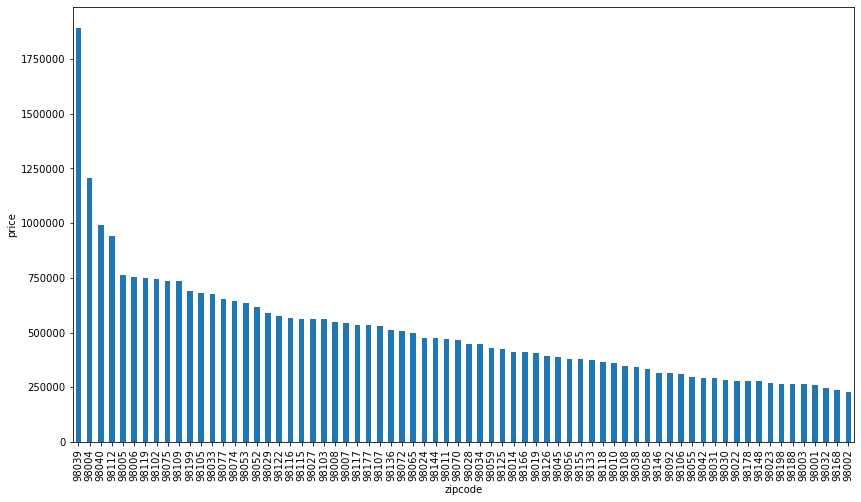

In [8]:
# median housing price per zipcode
zipcode_groupby = training_data.groupby(['zipcode']).price.median().sort_values(ascending=False)
plt.figure(figsize=(14,8))
plt.ylabel('price')
zipcode_groupby.plot(kind='bar');

#### Geohashing
In addition to looking at individual zipcodes, I will use geohashing based on haversine geodesic geometry using the geohash2 library. It divides up a geographic region into boxes and assigns a string to it. Neighbouring boxs share prefixes. But since we are going to be using dummy columns we aren't too concerned about that about proximity. Below, I plot out the relationsip between price and zipcode. As expected, there is a strong relationship between location and price. 

However, Geohashing is somewhat of a black box. We can decode the regions and see which are the most expensive?

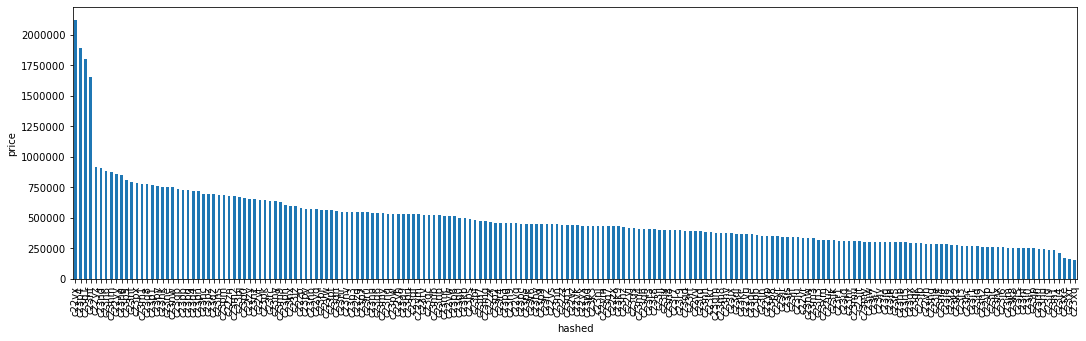

In [9]:
# create a location df with just lat and long
def geo_hash(lat, long):
    return geohash2.encode(lat, long, 5)

location = training_data[['lat', 'long']]
# create a hashed location column in the location data base
location['hashed_location'] =location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)

# Add the hashed_location to the training data
training_data['hashed'] = location.hashed_location

# plot the hashed data with price
plt.figure(figsize=(18,5))

plt.ylabel('price')
training_data.groupby(['hashed']).price.median().sort_values(ascending=False).plot(kind='bar');

In [10]:
# Let's decode the top four. I suspect they are also in Bellevue
top_4_geohashes = list(training_data.groupby(['hashed']).price.median().sort_values(ascending=False)[:10].index)

locations = [geohash2.decode(x) for x in top_4_geohashes]
locations
# No surprise, the are all in or the sound.

[('47.4', '-122.4'),
 ('47.7', '-122.2'),
 ('47.5', '-121.9'),
 ('47.6', '-122.2'),
 ('47.6', '-122.4'),
 ('47.6', '-122.2'),
 ('47.5', '-122.2'),
 ('47.5', '-122.1'),
 ('47.6', '-122.4'),
 ('47.6', '-122.2')]

### We have split the high price location into more regions and smoothed out our curve.
I will make dummy columns for the this data and the holdout data, see the supplementary notebooks `trainGeohashing.ipynb` and  `geohashingClustering.ipynb`.

Through visual analysis, it appears that 1 (98093) zipcode and 4 of the geohashes have signeficantly large mean house prices. Let's run a simple test to confirm that. 

### Conclusion on Spatial data

I have decided to dummy all of the zipcodes as well as all of the geolocations, the geolocations are finer grained and give location data on a better resolution than zipcode alone see `traingeohashing.ipynb` for the implementation

## Dealing with Time Series Data

I am not fully equiped to deal with time series data yet. However, I will do some binning and dummy creations as best as I can. In addition, I suspect there is a polynomial relationship between week of the year and price. 

Text(0, 0.5, 'Price')

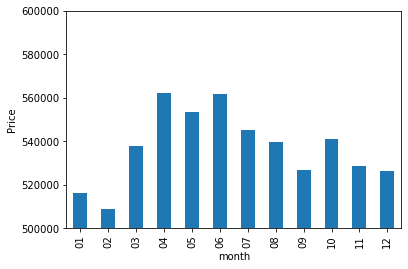

In [11]:
# Create a datetime object from the date column
datetime = pd.to_datetime(X.date)
# convert the date to months
month = datetime.dt.strftime("%m")
# append the months column to the dataframe
X['month'] = month
# Plot the month data against month
month_df = pd.concat([X['month'], y], axis=1)
month_df.groupby(['month']).price.mean().plot(kind='bar')
plt.ylim(500000,600000)
plt.ylabel('Price')

#### There is a seasonal fluctuation between months in price
I split the data into three broad categories. This was based on work done in the supplementary notebook `Months.ipynb`

(490000, 560000)

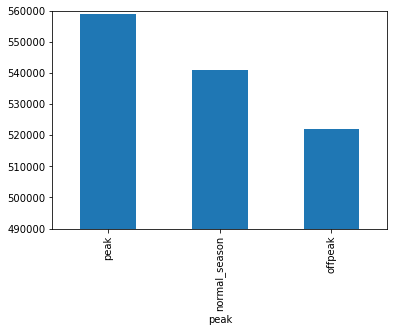

In [12]:
def peak_season(month):
    if month in [4,5,6]:
        return 'peak'
    elif month in [1,2,9,11,12]:
        return 'offpeak'
    else:
        return 'normal_season'
# set the month column to int
month_df.month = month_df.month.astype(int)
month_df['peak'] = month_df.month.apply(peak_season)  

# plot the results
month_df.groupby('peak').price.mean().sort_values(ascending=False).plot(kind='bar')
plt.ylim(490000, 560000)

#### I have a hypothesis that week vs price appears to be polynomial


(450000, 640000)

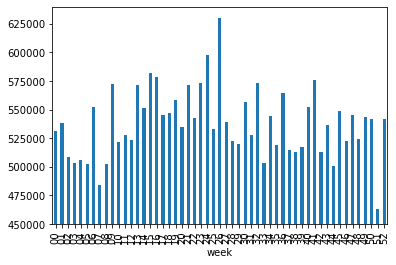

In [15]:
week = datetime.dt.strftime("%W")
week_df=month_df.copy()
week_df['week'] = week

week_df.groupby('week').price.mean().plot(kind='bar')
plt.ylim(450000, 640000)

In [33]:
week_df.week = week.astype(int)
week_df['week^2'] = week_df.week**2
week_df['week^3'] = week_df.week**3

formula1 = 'price~week+week^2+week^3'
formula2 = 'price~week'

model1 = ols(formula = formula1, data=week_df).fit()
model2 = ols(formula = formula2, data=week_df).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5361
Date:                Wed, 21 Oct 2020   Prob (F-statistic):              0.658
Time:                        10:43:36   Log-Likelihood:            -2.4637e+05
No. Observations:               17290   AIC:                         4.927e+05
Df Residuals:                   17286   BIC:                         4.928e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.452e+05   6199.865     87.933      0.000    5.33e+05    5.57e+05
week       -1051.4580   1437.414     -0.731      0.464   -3868.936    1766.020
week ^ 2   -1331.1049   3140.013     -0.424      0.672   -7485.848    4823.638
week ^ 3    2209.5423   2842.144      0.777      0.437   -3361.347    7780.432
==============================================================================
Omnibus:                    16034.197   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1123649.857
Skew:                           4.284   Prob(JB):                         0.00
Kurtosis:                      41.553   Cond. No.                         112.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Despite the insignificance of the result, in aggregate I found that the polynomial relationship decreased my RMSE

see the notebook `interactions.ipynb` for further details. A polynomial function for week up to x^3 will be included in my model. 

## Looking for over Interactions Between Features

First, I'll check for colinearity and then I will check for interactions between all features. I did my exploratory data analysis in `./eda/` and I will be referencing key findings as we progress through this notebook.

In [34]:
X = X.drop(columns = ['id', 'date'])
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,False,30,0,98058,47.4388,-122.162,2390,7700,10
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,True,39,0,98115,47.6784,-122.285,2370,6283,08
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,False,19,0,98006,47.5646,-122.129,3710,9685,08
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,False,26,0,98034,47.6995,-122.228,4050,14226,03
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,False,12,0,98052,47.6647,-122.083,2250,4050,07


In [35]:
# Split data into types
discrete_features = [
    'bedrooms',
    'bathrooms',
    'floors',
    'yr_built',
]

ordinal_features = [
    'condition',
    'grade',
    'zipcode',
    'view',   
]

continuous_features = [
    'sqft_living',
    'sqft_lot',
    'sqft_above',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'yr_renovated'
]

dummy = [
    'waterfront',
    'sqft_basement', # Since most are none at all, I will ultimately be treating this column like a dummy in my model
]

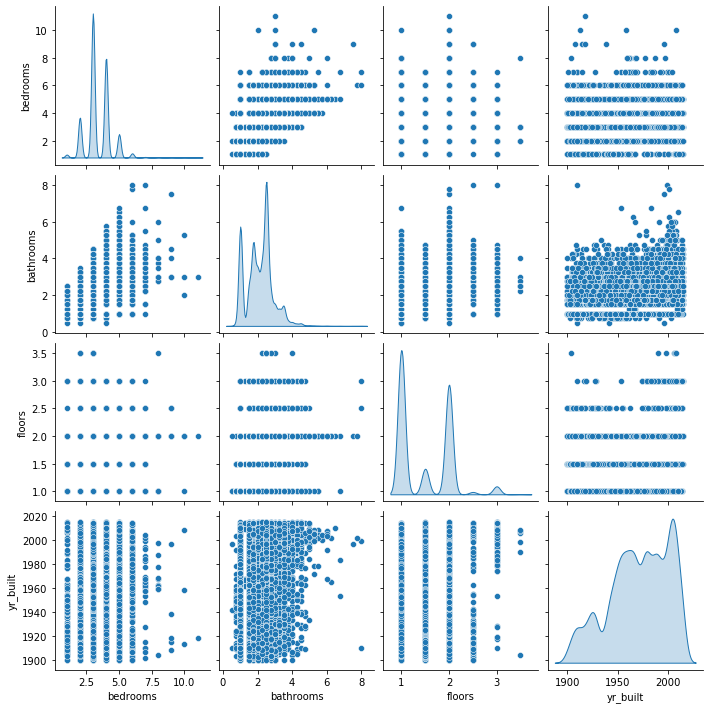

In [458]:
# Discrete Variables
sns.pairplot(X[discrete_features] , diag_kind='kde');

### Discrete feature first look

There seemes to interactions between yr_built and number of bathrooms as well as bathrooms and bedrooms. I would imaging that if the number of bathrooms and bedrooms are wildly different there would be a strong interaction there. So I will be sure to test a multiplicative feature there.

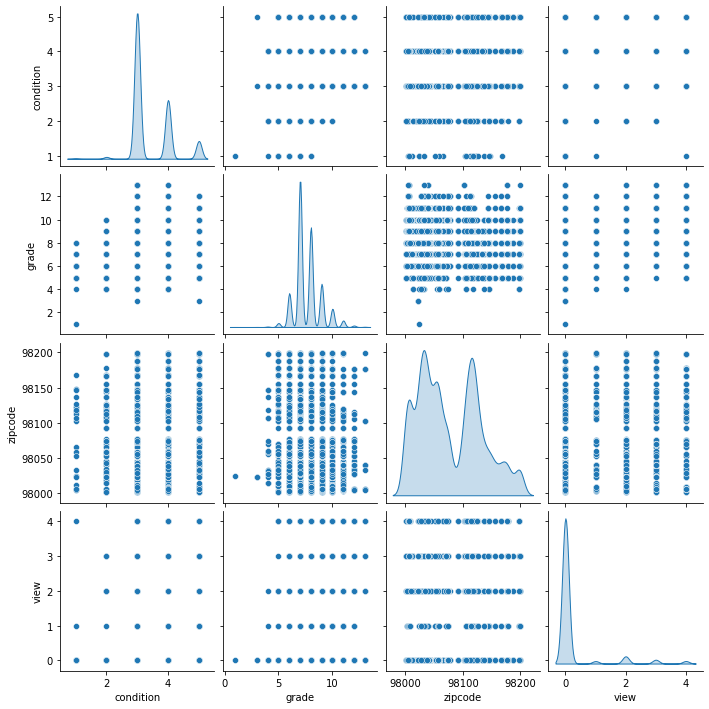

In [36]:
sns.pairplot(X[ordinal_features] , diag_kind='kde');

### Ordinal features first look

Zipcodes seems to be split into 2 peaks indicating two main cities perhapes? Our mapping analysis did revealed that Seatle is seperated by a sound, so the dip likely represents area of low density that are shared with the wataer front. These variables seem to be independent from one another on a visual inspection. However, You could imagine that something like zipcode and latitude may have a very strong influence on price together. If you are in the right neighbourhood and close to the water for instance. 

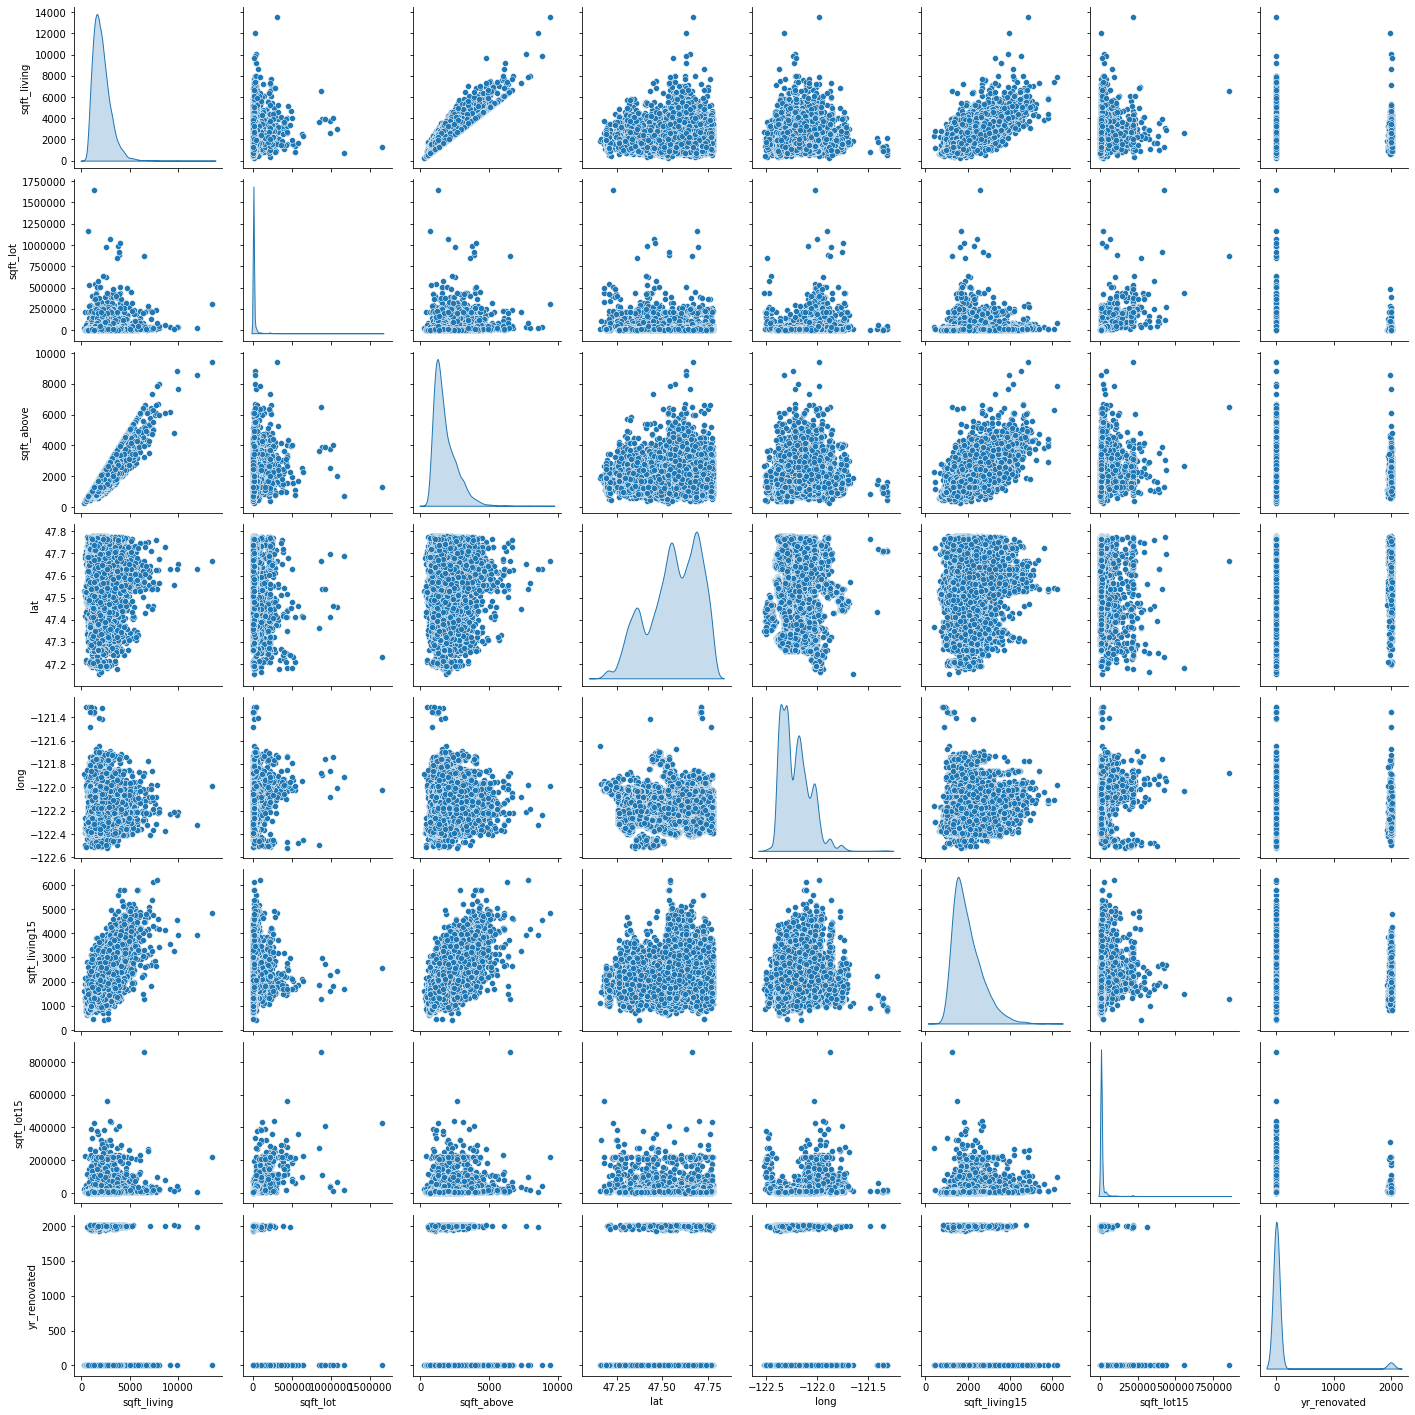

In [460]:
sns.pairplot(X[continuous_features] , diag_kind='kde');

## A lot of colinearity between features here.

I do not think that we care about colinearity when we are working with a predictive model. From this article:https://www.kdnuggets.com/2019/08/predictor-collinearity.html I gleaned that provided you have several thousand observations, the influence of colinearity becomes vastly less important for a predictive model. I don't want to drop any of the columns. 

However, some of the columns should be and will be transformed. In particular, any feature that looks at square foot

The one take away is potentially the sqft_basement may be better as a dummy column than a continuous variable since I would guess most people prefer

In [462]:
X.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,...,2070,False,1986,0,98058,47.4388,-122.162,2390,7700,10
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,...,1830,True,1977,0,98115,47.6784,-122.285,2370,6283,08
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,...,3770,False,1997,0,98006,47.5646,-122.129,3710,9685,08
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,...,4560,False,1990,0,98034,47.6995,-122.228,4050,14226,03
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,...,2550,False,2004,0,98052,47.6647,-122.083,2250,4050,07


# Creating a simple model to work from using standardised continuous and discrete variables

In [463]:
# split the data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [464]:
# Heavily skewed data to log transform
log_transform = [
    "sqft_lot15",
    "sqft_lot",
]

In [465]:
# make log dataframes of heavily skewed continuoous data

log_train = np.log(X_train[log_transform])
log_test = np.log(X_test[log_transform])
log_holdout = np.log(holdout[log_transform])

# Update the dataframe

X_train['log_sqft_lot15'] = log_train['sqft_lot15']
X_train['log_sqft_lot'] = log_train["sqft_lot"]

X_test['log_sqft_lot15'] = log_test['sqft_lot15']
X_test['log_sqft_lot'] = log_test['sqft_lot']

holdout['log_sqft_lot15'] = log_holdout['sqft_lot15']
holdout['log_sqft_lot'] = log_holdout['sqft_lot']

# drop old columns
def column_dropper(df_list, column_list):
    return (x.drop(columns=column_list) for x in df_list)

df_list = [X_train, X_test, holdout]

X_train, X_test, holdout = column_dropper(df_list, log_transform)

len(X_train.columns)

21

In [466]:
continuous_features = [
    'sqft_living',
    'log_sqft_lot',
    'sqft_above',
    'sqft_basement',
    'lat',
    'long',
    'sqft_living15',
    'log_sqft_lot15'
]

X_train[continuous_features]

,sqft_living,log_sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,log_sqft_lot15
2498,2370,8.585412,2370,False,47.7333,-121.975,2130,8.832004
10932,2080,9.519955,1040,True,47.4866,-122.232,1780,9.592810
15638,700,7.824046,700,False,47.5662,-122.364,1340,8.517193
15099,2490,8.886409,1460,True,47.3115,-122.396,2000,8.987197
15560,1970,8.532870,1680,True,47.5816,-122.296,1940,8.699515
...,...,...,...,...,...,...,...,...
11284,2240,8.634798,1520,True,47.5574,-122.308,2240,8.921991
11964,2710,8.735525,2710,False,47.3555,-122.061,2530,8.467793
5390,1650,8.881836,1650,False,47.7543,-122.344,1410,8.881836
860,1900,9.113499,1900,False,47.7684,-122.304,1900,9.462499


In [467]:
# I will normalize all the features apart from square footlot and sqft_, and  basement. I will do a log transform sqftlot and basement

train_standardize = X_train[continuous_features + discrete_features]

test_standardize =  X_test[continuous_features + discrete_features]

holdout_standardize = holdout[continuous_features + discrete_features]

### Instantiate the standard Scalar object

Moving forward, I will not worry about scaling my data

In [470]:
# instantiate my scalar
scalar = StandardScaler()

In [471]:
# Train data
X_train_stanDF = pd.DataFrame(scalar.fit_transform(train_standardize))
X_train_stanDF.columns = ["stan_" + x for x in train_standardize.columns]
# Test data
X_test_stanDF = pd.DataFrame(scalar.transform(test_standardize))
X_test_stanDF.columns = ["stan_" + x for x in test_standardize.columns]
# Holdout data
X_holdout_stand = pd.DataFrame(scalar.transform(holdout_standardize))
X_holdout_stand.columns = ["stan_" + x for x in test_standardize.columns]

In [472]:
# model using only continuous variables that have been normalized.
lr = LinearRegression()
lr.fit(X_train_stanDF, y_train)
y_hat = lr.predict(X_test_stanDF)
RMSE = mean_squared_error(y_test, y_hat)**0.5
RMSE

221943.70554190545

In [473]:
cross_val_score(estimator = lr, X=X_train_stanDF, y=y_train,  cv=5)

array([0.59809675, 0.63915956, 0.63306104, 0.63102748, 0.60486524])

### Now I will min max my ordinal variables and , the underlying distribution is not normal

In [474]:
# Scale the features and create a dataframe

# Train
train_ordinal_df = pd.DataFrame(minmax_scale(X_train[ordinal_features]))
train_ordinal_df.columns = ["mM_" + x for x in X_train[ordinal_features].columns]
# Test
test_ordinal_df = pd.DataFrame(minmax_scale(X_test[ordinal_features]))
test_ordinal_df.columns = ["mM_" + x for x in X_train[ordinal_features].columns]
# Holdout
holdout_ordinal_df = pd.DataFrame(minmax_scale(holdout[ordinal_features]))
holdout_ordinal_df.columns = ["mM_" + x for x in X_train[ordinal_features].columns]

len(X_train_stanDF), len(train_ordinal_df), len(X_train)

(13832, 13832, 13832)

In [475]:
lr = LinearRegression()
lr.fit(train_ordinal_df, y_train)
y_hat = lr.predict(test_ordinal_df)
RMSE = mean_squared_error(y_test, y_hat)**0.5
RMSE

335620.4894672923

In [476]:
# Create my partial data frames with all of the normalized and minmaxed data! Still missing waterfront and need to
# Drop zipcode once I have attached my dummies!

X_train_partial = pd.concat([train_ordinal_df, X_train_stanDF], axis = 1)

X_test_partial = pd.concat([test_ordinal_df, X_test_stanDF], axis = 1)

holdout_partial = pd.concat([holdout_ordinal_df, X_holdout_stand], axis=1)

In [477]:
lr = LinearRegression()
lr.fit(X_train_partial, y_train)
y_hat = lr.predict(X_test_partial)
RMSE = mean_squared_error(y_test, y_hat)**0.5
RMSE

230222.55098554544

In [478]:
cross_val_score(estimator = lr, X=X_train_partial, y=y_train,  cv=5)

array([0.6530325 , 0.69773683, 0.70656831, 0.67959741, 0.66578751])

In [480]:
X_train_partial.columns

Index(['mM_condition', 'mM_grade', 'mM_zipcode', 'mM_view', 'stan_sqft_living',
       'stan_log_sqft_lot', 'stan_sqft_above', 'stan_sqft_basement',
       'stan_lat', 'stan_long', 'stan_sqft_living15', 'stan_log_sqft_lot15',
       'stan_bedrooms', 'stan_bathrooms', 'stan_floors', 'stan_yr_built'],
      dtype='object')

# Get my dummy columns for month and Geohash into the models

In [481]:
def geo_hash(lat, long):
    return geohash2.encode(lat, long, 5)

# Train data
train_location = X_train[['lat', 'long']]
train_location['hashed_location'] = train_location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)
# Test data
test_location = X_test[['lat', 'long']]
test_location['hashed_location'] = train_location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)
# holdout 
holdout_location = holdout[['lat', 'long']]
holdout_location['hashed_location'] = train_location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)


In [482]:
# Get dummies for location 
test_loc_dummies = pd.get_dummies(test_location.hashed_location)
train_loc_dummies = pd.get_dummies(train_location.hashed_location)
holdout_loc_dummies = pd.get_dummies(holdout_location.hashed_location)

In [483]:
# Get dummies for the season, add the datetime back into the dataframe and specificy month

# train and test
X_date = pd.read_csv('./cleanedData/X.imputed.csv')
x_date = pd.to_datetime(X_date.date)
month = x_date.dt.strftime("%m")
X_date['month'] = month.astype(int)

# holdout
holdout['month'] = pd.to_datetime(holdout.date)
holdout.month = holdout.month.dt.strftime("%m").astype(int)

In [484]:
def peak_season(month):
    if month in [4,5,6]:
        return 'peak'
    elif month in [1,2,9,11,12]:
        return 'offpeak'
    else:
        return 'normal_season'



In [485]:

X_train_month, X_test_month, y_train, y_test = train_test_split(X_date, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [486]:
# get columns for season
train_season = X_train_month.month.apply(peak_season)
test_season = X_test_month.month.apply(peak_season)
holdout_season = holdout.month.apply(peak_season)

In [487]:
# Get dummies 
train_sea_dummies = pd.get_dummies(train_season)
test_sea_dummies = pd.get_dummies(test_season)
holdout_season = pd.get_dummies(holdout_season)

In [488]:
# concat to the dataframes:
train_partial = pd.concat([train_sea_dummies, X_train_partial], axis=1)
test_partial = pd.concat([test_sea_dummies, X_test_partial], axis=1)
holdout_partial_ = pd.concat([holdout_season, holdout_partial], axis=1)

,normal_season,offpeak,peak,mM_condition,mM_grade,mM_zipcode,mM_view,stan_sqft_living,stan_log_sqft_lot,stan_sqft_above,stan_sqft_basement,stan_lat,stan_long,stan_sqft_living15,stan_log_sqft_lot15,stan_bedrooms,stan_bathrooms,stan_floors,stan_yr_built
0,NaN,NaN,NaN,0.50,0.583333,0.090909,0.0,0.303347,-0.458139,0.692442,-0.808184,1.247913,1.710368,0.202325,-0.167147,-0.408610,0.495521,0.939467,1.298749
1,1.0,0.0,0.0,0.75,0.500000,0.893939,0.0,-0.009382,0.579752,-0.905810,1.237342,-0.533320,-0.121863,-0.306301,0.766828,0.681226,-0.473751,-0.913611,-0.539340
2,1.0,0.0,0.0,0.75,0.500000,0.530303,0.0,-1.497543,-1.303703,-1.314385,-0.808184,0.041411,-1.062931,-0.945716,-0.553612,-2.588281,-1.443022,-0.913611,-2.173197
3,NaN,NaN,NaN,0.50,0.583333,0.111111,0.0,0.432752,-0.123856,-0.401099,1.237342,-1.797584,-1.291069,0.013407,0.023370,0.681226,0.172430,-0.913611,0.243549
4,1.0,0.0,0.0,0.50,0.583333,0.722222,0.0,-0.128004,-0.516492,-0.136726,1.237342,0.152603,-0.578138,-0.073786,-0.329792,-0.408610,1.787883,0.939467,1.230671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17282,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17283,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17284,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17287,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [441]:
lr = LinearRegression()
lr.fit(train_partial, y_train)
y_hat = lr.predict(test_partial)
RMSE = mean_squared_error(y_test, y_hat)**0.5
RMSE

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').